# Empirical Bayes Chapter 9

In this chapter we will develop a mixture model approach that will describe both Pitchers and Non-Pitchers alike. I do not know of a Python package that has mixture models of Beta-Binomial models implemented directly, so we will iplement our own expectation-maximation algorithm ourselves. Let's load some packages:

In [44]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
from scipy.optimize import minimize
from scipy.special import gammaln, logit, digamma
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set(style="darkgrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Let's create our dataset:

In [2]:
# import batting pitching and people dataset
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
people = pd.read_csv("~/baseball/core/People.csv")

# tagging pitchers with 4+ games
pitching = pitching.groupby("playerID").agg({"G": "sum"}).reset_index()
pitching = pitching.loc[pitching["G"]>3]
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting["is_pitcher"] = batting_pitchers

# create batting average dataset (sum over years)
batting = batting.loc[(batting["AB"] > 0) & (batting["yearID"] >= 1980) & (batting["lgID"] == "NL") ]
batting = batting.groupby("playerID").agg({"AB": "sum", "H": "sum", "yearID":"mean", "is_pitcher": "mean"}).reset_index()
batting["average"] = batting["H"]/batting["AB"]

# add actual player name and pitcher tags
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name", "bats"]], on="playerID")

Let's plot the histograms of the combined distribution and highlight the pitchers and non-pitchers

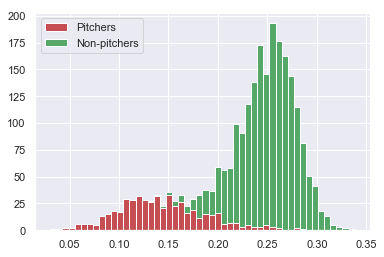

In [3]:
plt.hist([batting.loc[(batting["AB"]>100) & (batting["is_pitcher"]==True)]["average"],
          batting.loc[(batting["AB"]>100) & (batting["is_pitcher"]==False)]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["Pitchers", "Non-pitchers"]);
plt.legend()

We can see that these are two very different distributions and it seems obvious that fitting one combined distribution would be very suboptimal! Just for fun, let's fit a beta distribution to the whole data and visualize the result:

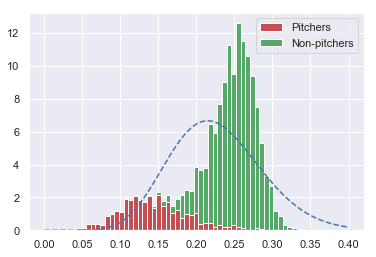

In [4]:
param = st.beta.fit(batting.loc[(batting["AB"]>100)]["average"].values, floc=0, fscale=1)
x = np.linspace(0,0.4,1000)
pdf_fitted = st.beta.pdf(x,a=param[0],b=param[1])
plt.hist([batting.loc[(batting["AB"]>100) & (batting["is_pitcher"]==True)]["average"],
          batting.loc[(batting["AB"]>100) & (batting["is_pitcher"]==False)]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["Pitchers", "Non-pitchers"], density=True);
plt.legend()
plt.plot(x,pdf_fitted,'--')
plt.show()

Assuming we didn't know which player is a pitcher and which isn't (not necessarily realistic), how could we improve our model in order to fit this more complicated situation? The answer to this is a mixture model where we will fit a combination of two beta distributions using a expectation-maximation algorithm. We will start by randomly splitting our dataset into two parts:

In [5]:
cluster_batting = batting.loc[(batting["AB"]>=20)]

cluster_batting["cluster"] = "A"
cluster_batting.loc[cluster_batting.sample(frac=0.5, replace=False).index,'cluster'] = 'B'

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
def loglike_betabinom(params, *args):

    k = args[0] # the number of hits
    n = args[1] # the number of at-bats (AE)

    alpha = params[0]
    beta = params[1]
    
    logpdf = gammaln(n+1) + gammaln(k+alpha) + gammaln(n-k+beta) + gammaln(alpha+beta) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(alpha) + gammaln(beta) + gammaln(n+alpha+beta))

    mask = np.isfinite(logpdf)
    nll = -logpdf[mask].sum()
    return nll

In [7]:
def fit_beta_binomial(x, n):
    """Function to fit a beta distribution
    """
    init_params = [3, 10]
    res = minimize(loglike_betabinom, x0=init_params,
            args=(x, n),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 500},
              bounds=[(1, None), (1, None)])
    return res

We can now use this function to again fit our whole data, which will yield the same as before:

In [8]:
res = fit_beta_binomial(np.array(cluster_batting["H"]), np.array(cluster_batting["AB"]))

In [9]:
res.x

array([12.40433533, 44.46495853])

Now, we will use our clustered data and use our function to fit each cluster individually. Since we assigned the clusters randomly, both results should be very similar, but still slightly different:

In [10]:
res_a = fit_beta_binomial(np.array(cluster_batting.loc[cluster_batting["cluster"]=="A"]["H"]), 
                          np.array(cluster_batting.loc[cluster_batting["cluster"]=="A"]["AB"]))
res_b = fit_beta_binomial(np.array(cluster_batting.loc[cluster_batting["cluster"]=="B"]["H"]), 
                          np.array(cluster_batting.loc[cluster_batting["cluster"]=="B"]["AB"]))

Let's take a look at our two fitted distributions:

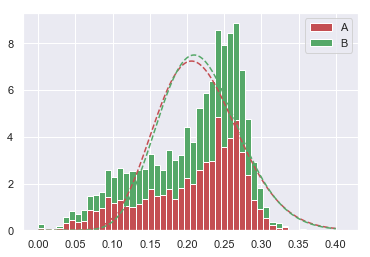

In [11]:
x = np.linspace(0,0.4,1000)
pdf_fitted_a = st.beta.pdf(x,a=res_a.x[0],b=res_a.x[1])
pdf_fitted_b = st.beta.pdf(x,a=res_b.x[0],b=res_b.x[1])
plt.hist([cluster_batting.loc[(cluster_batting["cluster"]=="A")]["average"],
          cluster_batting.loc[(cluster_batting["cluster"]=="B")]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["A", "B"], density=True);
plt.legend()
plt.plot(x,pdf_fitted_a,'r--')
plt.plot(x,pdf_fitted_b,'g--')
plt.show()

Now that we have two differnent distributions, we can calculate the likelihood that a specific result came from each of these distributions. For this, we can use the `loglike_betabinom`-function that we defined above. It calculates the negative logarithm of the likelihood, so we will use a factor of `-1` and the exponential function to turn the output into a probability. As an example, we can use Jeff Abbott, who had 11 hits out of 42 at-bats:

In [12]:
np.exp(-loglike_betabinom([res_a.x[0], res_a.x[1]], 11, 42))

0.08836124134718037

In [13]:
np.exp(-loglike_betabinom([res_b.x[0], res_b.x[1]], 11, 42))

0.09122159918620237

We can see, that he had a higher probability using the values of cluster B (9.1% vs 8.9%). Now, in out maximization step, we will assign him to our cluster A, since the probability is higher. We can now do this for our whole dataframe. I have to use `df.apply` here, because the log-likelihood function is vectorized and would otherwise calculate the likelihood for the whole sample and not just row wise:

In [14]:
def comparison(x, n):
    """Helper function to calculate which cluster is more likely
    """
    if (np.exp(-loglike_betabinom([res_a.x[0], res_a.x[1]], x, n)) >
         np.exp(-loglike_betabinom([res_b.x[0], res_b.x[1]], x, n))):
        return "A"
    else:
        return "B"

In [15]:
cluster_batting["cluster"] = cluster_batting.apply(lambda row: comparison(row["H"], row["AB"]), axis=1)

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


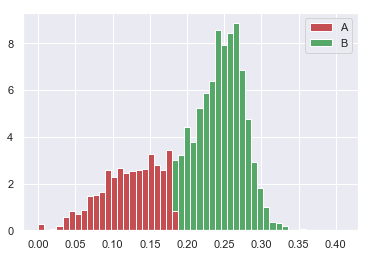

In [16]:
x = np.linspace(0,0.4,1000)
plt.hist([cluster_batting.loc[(cluster_batting["cluster"]=="A")]["average"],
          cluster_batting.loc[(cluster_batting["cluster"]=="B")]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["A", "B"], density=True);
plt.legend()
plt.show()

We could now fit again our two beta distributions:

In [17]:
res_a = fit_beta_binomial(np.array(cluster_batting.loc[cluster_batting["cluster"]=="A"]["H"]), 
                          np.array(cluster_batting.loc[cluster_batting["cluster"]=="A"]["AB"]))
res_b = fit_beta_binomial(np.array(cluster_batting.loc[cluster_batting["cluster"]=="B"]["H"]), 
                          np.array(cluster_batting.loc[cluster_batting["cluster"]=="B"]["AB"]))

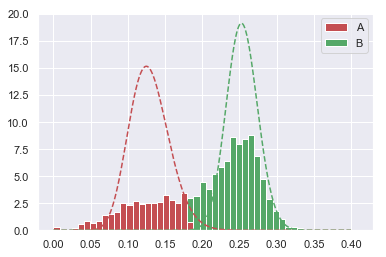

In [18]:
x = np.linspace(0,0.4,1000)
pdf_fitted_a = st.beta.pdf(x,a=res_a.x[0],b=res_a.x[1])
pdf_fitted_b = st.beta.pdf(x,a=res_b.x[0],b=res_b.x[1])
plt.hist([cluster_batting.loc[(cluster_batting["cluster"]=="A")]["average"],
          cluster_batting.loc[(cluster_batting["cluster"]=="B")]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["A", "B"], density=True);
plt.legend()
plt.plot(x,pdf_fitted_a,'r--')
plt.plot(x,pdf_fitted_b,'g--')
plt.show()

This already looks much better than before. We should obviously do this procedure a couple of more times. Let's write a function that can run the whole thing `n` times:

In [19]:
def expectation_maximation(data, x, n, n_iter=10, cluster_column="cluster"):
    """run expectation maximation
    
    Parameters
    ----------
    data: pd.DataFrame
        Input dataframe
    x: str
        Column name for the hits column
    n: str
        Column name for the at-bats column
    n_iter: int, optional
        Number of iterations. The default is 10
    cluster_column: str, optional
        Name of the cluster column. The default is "cluster".
    
    Returns
    -------
    scipy.optimize.optimize.OptimizeResult
        Optmize result for cluster A
    scipy.optimize.optimize.OptimizeResult
        Optimize result for cluster B
    """
    for i in range(n_iter):
        # fit two beta binomial distributions
        res_a = fit_beta_binomial(np.array(data.loc[data[cluster_column]=="A"][x]), 
                              np.array(data.loc[data[cluster_column]=="A"][n]))
        res_b = fit_beta_binomial(np.array(data.loc[data[cluster_column]=="B"][x]), 
                              np.array(data.loc[data[cluster_column]=="B"][n]))
        
        # update clusters
        data[cluster_column] = data.apply(lambda row: comparison(row[x], row[n]), axis=1)
       
    # fit one last beta binomial distribution
    res_a = fit_beta_binomial(np.array(data.loc[data[cluster_column]=="A"][x]), 
                              np.array(data.loc[data[cluster_column]=="A"][n]))
    res_b = fit_beta_binomial(np.array(data.loc[data[cluster_column]=="B"][x]), 
                              np.array(data.loc[data[cluster_column]=="B"][n]))
        
    return res_a, res_b

In [20]:
res_a, res_b = expectation_maximation(cluster_batting, "H", "AB")

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Let's see the results after 10 iterations:

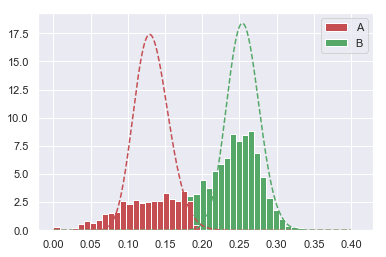

In [21]:
x = np.linspace(0,0.4,1000)
pdf_fitted_a = st.beta.pdf(x,a=res_a.x[0],b=res_a.x[1])
pdf_fitted_b = st.beta.pdf(x,a=res_b.x[0],b=res_b.x[1])
plt.hist([cluster_batting.loc[(cluster_batting["cluster"]=="A")]["average"],
          cluster_batting.loc[(cluster_batting["cluster"]=="B")]["average"]],
          bins=50, stacked=True, color = ['r','g'], label=["A", "B"], density=True);
plt.legend()
plt.plot(x,pdf_fitted_a,'r--')
plt.plot(x,pdf_fitted_b,'g--')
plt.show()

Let's check how our clustering did when compared to the actual pitcher/non-pitcher data:

In [22]:
confusion_matrix(cluster_batting["is_pitcher"], np.where(cluster_batting["cluster"] == "A", True, False))

array([[2241,  280],
       [ 159,  935]])

Let's calculate the probability that a player is a pitcher (belongs to column A). We can calculate this by using Bayes theorem and calculate the ratio of the likelihood for cluster A divided by the sum of the likelihoods from cluster A and B:

In [23]:
def probability_a(x, n):
    """helper function to calculate cluster A probability
    """
    return (np.exp(-loglike_betabinom([res_a.x[0], res_a.x[1]], x, n))/
         (np.exp(-loglike_betabinom([res_a.x[0], res_a.x[1]], x, n)) + np.exp(-loglike_betabinom([res_b.x[0], res_b.x[1]], x, n))))

In [24]:
cluster_batting["probability_a"] = cluster_batting.apply(lambda row: probability_a(row["H"], row["AB"]), axis=1)

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
cluster_batting.head()

,playerID,AB,H,yearID,is_pitcher,average,name,bats,cluster,probability_a
4,abbotje01,42,11,2001.0,False,0.261905,Jeff Abbott,R,B,0.109593
5,abbotji01,21,2,1999.0,True,0.095238,Jim Abbott,L,A,0.818184
6,abbotku01,1860,475,1997.5,False,0.255376,Kurt Abbott,R,B,0.000085
7,abbotky01,31,3,1993.5,True,0.096774,Kyle Abbott,L,A,0.895085
9,abercre01,386,86,2007.0,False,0.222798,Reggie Abercrombie,R,B,0.027253


With this we can now calculate the shrunken batting average using our mixture model:

In [26]:
cluster_batting["alpha_a"] = res_a.x[0] + cluster_batting["H"]
cluster_batting["alpha_b"] = res_b.x[0] + cluster_batting["AB"] - cluster_batting["H"]
cluster_batting["beta_a"] = res_a.x[1] + cluster_batting["H"]
cluster_batting["beta_b"] = res_b.x[1] + cluster_batting["AB"] - cluster_batting["H"]

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [27]:
cluster_batting["eb_average"] = (cluster_batting["probability_a"] 
                                 * (res_a.x[0] + cluster_batting["H"])
                                 /(res_a.x[0] + res_a.x[1] + cluster_batting["AB"])
                                 + (1 - cluster_batting["probability_a"])
                                 * (res_b.x[0] + cluster_batting["H"])
                                 /(res_b.x[0] + res_b.x[1] + cluster_batting["AB"])
                                )

/Users/Jan/anaconda3/envs/euler/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We can see that the effect of the bayesian shrinkage shrinks is slightly different as in the simple beta case: Here, we pull the averages towards two centers instead of one:

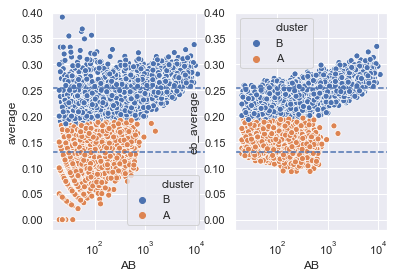

In [29]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(cluster_batting["AB"], cluster_batting["average"], ax=ax[0], hue=cluster_batting["cluster"])
sns.scatterplot(cluster_batting["AB"], cluster_batting["eb_average"], ax=ax[1], hue=cluster_batting["cluster"])
ax[0].set_xscale('log')
ax[0].set(ylim=(-0.02, 0.4));
ax[1].set_xscale('log')
ax[1].set(ylim=(-0.02, 0.4));
ax[0].axhline(0.13, ls='--');
ax[1].axhline(0.13, ls='--');
ax[0].axhline(0.255, ls='--');
ax[1].axhline(0.255, ls='--');

Let's look at some players with 100 at-bats and plot their posterior probability distributions:

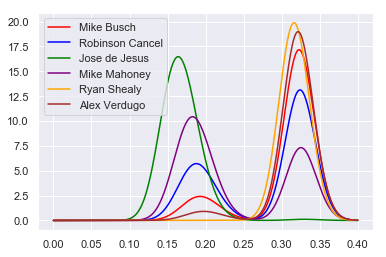

In [30]:
player_100 = cluster_batting.loc[cluster_batting["AB"]==100]
names = list(player_100["name"].values)
for name, color in zip(names, ["red", "blue", "green", "purple", "orange", "brown"]):
    name_data = player_100.loc[player_100["name"] == name]
    
    x = np.linspace(0,0.4,1000)
    pdf_fitted_a = st.beta.pdf(x,a=name_data["alpha_a"],b=name_data["beta_a"])
    pdf_fitted_b = st.beta.pdf(x,a=name_data["alpha_b"],b=name_data["beta_b"])
    total = name_data["probability_a"].values * pdf_fitted_a + (1 - name_data["probability_a"].values) * pdf_fitted_b

    plt.plot(x,total, color, label=name)
plt.legend()
plt.show()

Just for fun, let's do some MCMC to fit a beta binomial mixture model:

In [32]:
AB = np.array(cluster_batting["AB"])
H = np.array(cluster_batting["H"])

In [38]:
import pymc3 as pm

with pm.Model() as model:
    alpha1 = pm.Uniform("alpha1", lower=1, upper=200)
    beta1 = pm.Uniform("beta1", lower=1, upper=500)
    alpha2 = pm.Uniform("alpha2", lower=1, upper=200)
    beta2 = pm.Uniform("beta2", lower=1, upper=500)
    w = pm.Dirichlet('w', a=np.array([1, 1]))
    b1 = pm.BetaBinomial.dist(alpha=alpha1, beta=beta1, n=AB)
    b2 = pm.BetaBinomial.dist(alpha=alpha2, beta=beta2, n=AB)
    mix = pm.Mixture("mix", w=w, comp_dists=[b1, b2], observed=H)
    trace_nuts = pm.sample(10000, step=pm.NUTS(vars=[alpha1, beta1, alpha2, beta2, w, mix]), init="advi+adapt_diag")

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, beta2, alpha2, beta1, alpha1]
Sampling 2 chains: 100%|██████████| 21000/21000 [34:10<00:00,  5.04draws/s] 


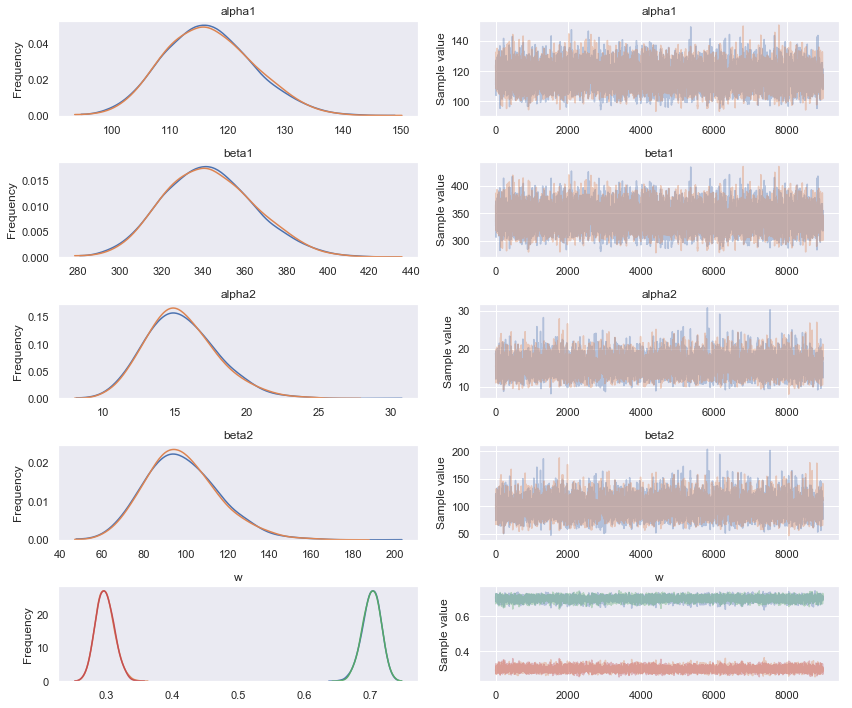

In [43]:
figsize(20, 12)
pm.traceplot(trace_nuts[1000:], ['alpha1', 'beta1', "alpha2", "beta2", "w"]);